## Power generation Forecasting
by Hoang cute

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Read the datasets
import glob
path = r'.\new_dataset' # use your path
filename = path + "/main_data.csv"

df = pd.read_csv(filename, index_col=None, header=0,encoding = 'unicode_escape')

In [4]:
df.head()

,datetime,Temperature,precipitation,wind,Wind direction (16 directions),humidity,Vapor pressure,Dew point temperature,Local pressure,Sea level pressure,...,Visibility (10m),ground condition (ground condition code),Prize number (domestic),Ground temperature (°C),5 cm underground temperature (°C),10 cm underground temperature (°C),20 cm underground temperature (°C),30 cm underground temperature (°C),F_all_power,Power
0,2021-01-01 0:00,-8.3,NaN,1.8,250.0,66,2.2,-13.5,1016.4,1027.7,...,2000.0,NaN,NaN,-6.8,-0.9,-0.7,0.3,1.6,114772,0
1,2021-01-01 1:00,-8.7,NaN,2.4,270.0,68,2.2,-13.5,1016.4,1027.7,...,2000.0,NaN,NaN,-6.9,-1.0,-0.8,0.3,1.6,114772,0
2,2021-01-01 2:00,-9.1,NaN,1.6,270.0,69,2.1,-13.7,1016.2,1027.5,...,2000.0,NaN,NaN,-7.1,-1.1,-0.8,0.3,1.6,114772,0
3,2021-01-01 3:00,-9.3,NaN,1.1,250.0,70,2.1,-13.7,1016.8,1028.1,...,2000.0,NaN,NaN,-7.3,-1.2,-0.9,0.3,1.6,114772,0
4,2021-01-01 4:00,-9.3,NaN,0.3,0.0,71,2.2,-13.5,1016.2,1027.5,...,2000.0,NaN,NaN,-7.5,-1.3,-1.0,0.2,1.5,114772,0


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').fillna(0)

In [6]:
print(len(df))

17520


In [7]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [8]:
df_merge = df_convert_dtypes(df, np.object, np.float64)
df_merge = df_convert_dtypes(df_merge, np.int64, np.float64)

In [9]:
print(len(df_merge))

17520


In [10]:
df_merge.describe()

,Temperature,precipitation,wind,Wind direction (16 directions),humidity,Vapor pressure,Dew point temperature,Local pressure,Sea level pressure,daylight (hr),...,Visibility (10m),ground condition (ground condition code),Prize number (domestic),Ground temperature (°C),5 cm underground temperature (°C),10 cm underground temperature (°C),20 cm underground temperature (°C),30 cm underground temperature (°C),F_all_power,Power
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,...,17520.000000,17520.0,1.752000e+04,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,13.806027,0.131199,2.431975,184.083333,67.421176,12.901010,7.133271,1008.902066,1016.421838,0.247877,...,2016.233676,0.0,1.658249e+03,14.968779,15.328191,15.034937,15.067061,15.264463,143838.613071,15.325571
std,10.439376,1.089827,1.471279,107.778813,20.907666,8.469466,11.797870,8.289812,8.059469,0.395527,...,1100.270918,0.0,1.452714e+05,11.950873,10.050382,9.841739,9.408285,8.890834,55102.580412,23.330653
min,-18.500000,0.000000,0.000000,0.000000,10.000000,0.500000,-30.800000,986.900000,996.500000,0.000000,...,0.000000,0.0,0.000000e+00,-12.700000,-7.200000,-5.200000,-3.000000,-0.800000,33391.000000,0.000000
25%,6.100000,0.000000,1.400000,70.000000,51.000000,5.900000,-0.400000,1002.800000,1010.200000,0.000000,...,1334.000000,0.0,0.000000e+00,5.000000,6.600000,6.400000,6.700000,7.300000,111316.000000,0.000000
50%,14.800000,0.000000,2.200000,200.000000,69.000000,9.900000,6.900000,1009.100000,1016.700000,0.000000,...,2000.000000,0.0,0.000000e+00,15.900000,15.800000,15.300000,15.100000,15.400000,142575.500000,1.000000
75%,22.200000,0.000000,3.200000,270.000000,86.000000,20.500000,17.900000,1015.200000,1022.400000,0.500000,...,2142.000000,0.0,0.000000e+00,23.700000,23.900000,23.600000,23.600000,23.500000,182487.000000,24.000000
max,36.500000,64.700000,11.600000,360.000000,100.000000,34.600000,26.500000,1031.900000,1037.400000,1.000000,...,5000.000000,0.0,1.916020e+07,56.800000,41.000000,38.600000,34.500000,31.600000,241189.000000,132.000000


In [11]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(20, 12))
    #ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label,linewidth=6)
        ax.set_ylabel(ylabel, fontsize=30)
    if series.any():
        ax.plot(series, label=label,linewidth=6)
        ax.set_ylabel(ylabel, fontsize=30)
    if label:
        ax.legend(fontsize=30)
    if title:
        ax.set_title(title, fontsize=30)
    fig.autofmt_xdate()
    power = df['Power']
    t_average = power.rolling(window=5).mean()
    plt.plot(t_average, 'r--', label='Running average',linewidth = 4)
    ax.grid(True)
    return ax


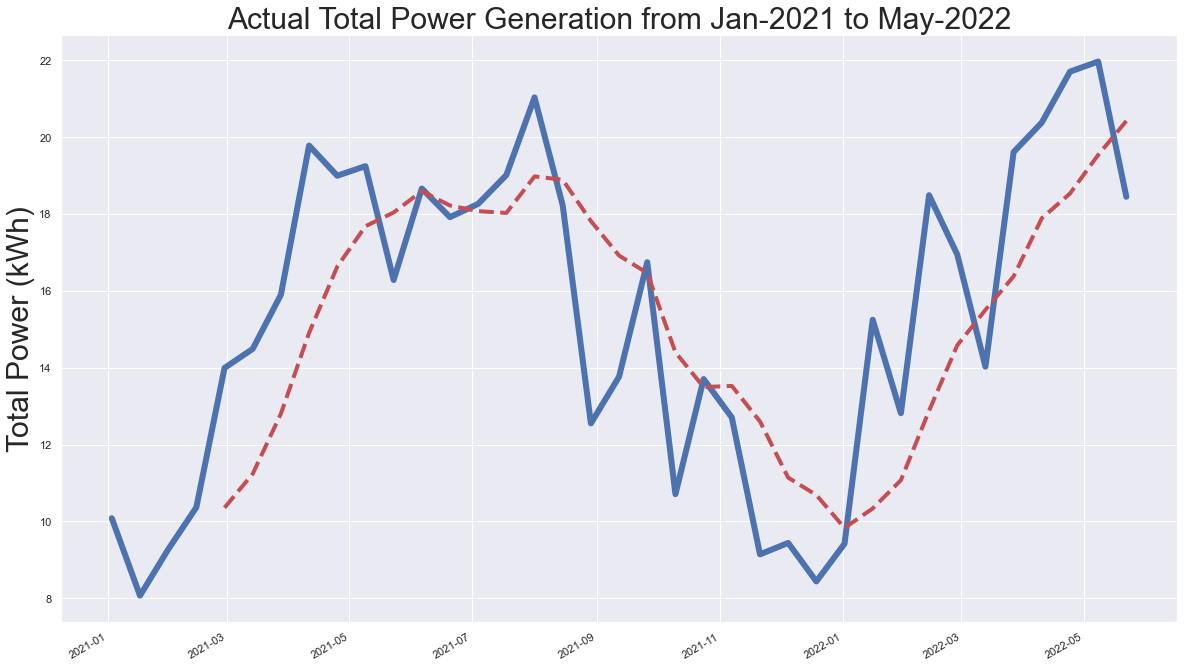

In [12]:
    # Zoom into the plot of the hourly (actual) total load
dfffffff= df_merge[:12000].resample('2W').mean()
ax = plot_series(df=dfffffff, column='Power', ylabel='Total Power (kWh)',
                 title='Actual Total Power Generation from Jan-2021 to May-2022', end=None)
plt.show()

In [13]:
# Display the rows with null values

df_merge[df_merge.isnull().any(axis=1)].tail()

,Temperature,precipitation,wind,Wind direction (16 directions),humidity,Vapor pressure,Dew point temperature,Local pressure,Sea level pressure,daylight (hr),...,Visibility (10m),ground condition (ground condition code),Prize number (domestic),Ground temperature (°C),5 cm underground temperature (°C),10 cm underground temperature (°C),20 cm underground temperature (°C),30 cm underground temperature (°C),F_all_power,Power
datetime,,,,,,,,,,,,,,,,,,,,,


In [14]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_merge.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

Temperature                                   17493
precipitation                                  1078
wind                                          17453
Wind direction (16 directions)                16924
humidity                                      17520
Vapor pressure                                17520
Dew point temperature                         17428
Local pressure                                17520
Sea level pressure                            17520
daylight (hr)                                  5860
Solar radiation (MJ/m2)                        9222
snow cover (cm)                                 365
3-hour snowfall (cm)                             20
Total cloudiness (10th percentile)            12569
Lower middle cloud cover (10th percentile)     8805
Minimum Ceiling (100m)                         8091
Visibility (10m)                              17487
ground condition (ground condition code)          0
Prize number (domestic)        

## <a id='ref14'>2.3. Autocorrelation, partial autocorrelation and cross-correlation</a> 

In [15]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2021-01-01 00:00:00 to 2022-12-31 22:59:00
Data columns (total 26 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Temperature                                 17520 non-null  float64
 1   precipitation                               17520 non-null  float64
 2   wind                                        17520 non-null  float64
 3   Wind direction (16 directions)              17520 non-null  float64
 4   humidity                                    17520 non-null  float64
 5   Vapor pressure                              17520 non-null  float64
 6   Dew point temperature                       17520 non-null  float64
 7   Local pressure                              17520 non-null  float64
 8   Sea level pressure                          17520 non-null  float64
 9   daylight (hr)                               1752

In [16]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_merge.corr(method='spearman')
print(correlations.columns)
print(correlations['Power'].sort_values(ascending=False).to_string())

Index(['Temperature', 'precipitation', 'wind',
       'Wind direction (16 directions)', 'humidity', 'Vapor pressure',
       'Dew point temperature ', 'Local pressure', 'Sea level pressure ',
       'daylight (hr)', 'Solar radiation (MJ/m2)', 'snow cover (cm)',
       '3-hour snowfall (cm)', 'Total cloudiness (10th percentile)',
       'Lower middle cloud cover (10th percentile)', 'Minimum Ceiling (100m)',
       'Visibility (10m)', 'ground condition (ground condition code)',
       'Prize number (domestic)', 'Ground temperature (°C)',
       '5 cm underground temperature (°C)',
       '10 cm underground temperature (°C)',
       '20 cm underground temperature (°C)',
       '30 cm underground temperature (°C)', 'F_all_power', 'Power'],
      dtype='object')
Power                                         1.000000
Solar radiation (MJ/m2)                       0.976045
daylight (hr)                                 0.806360
Ground temperature (°C)                       0.474012
Temperature 

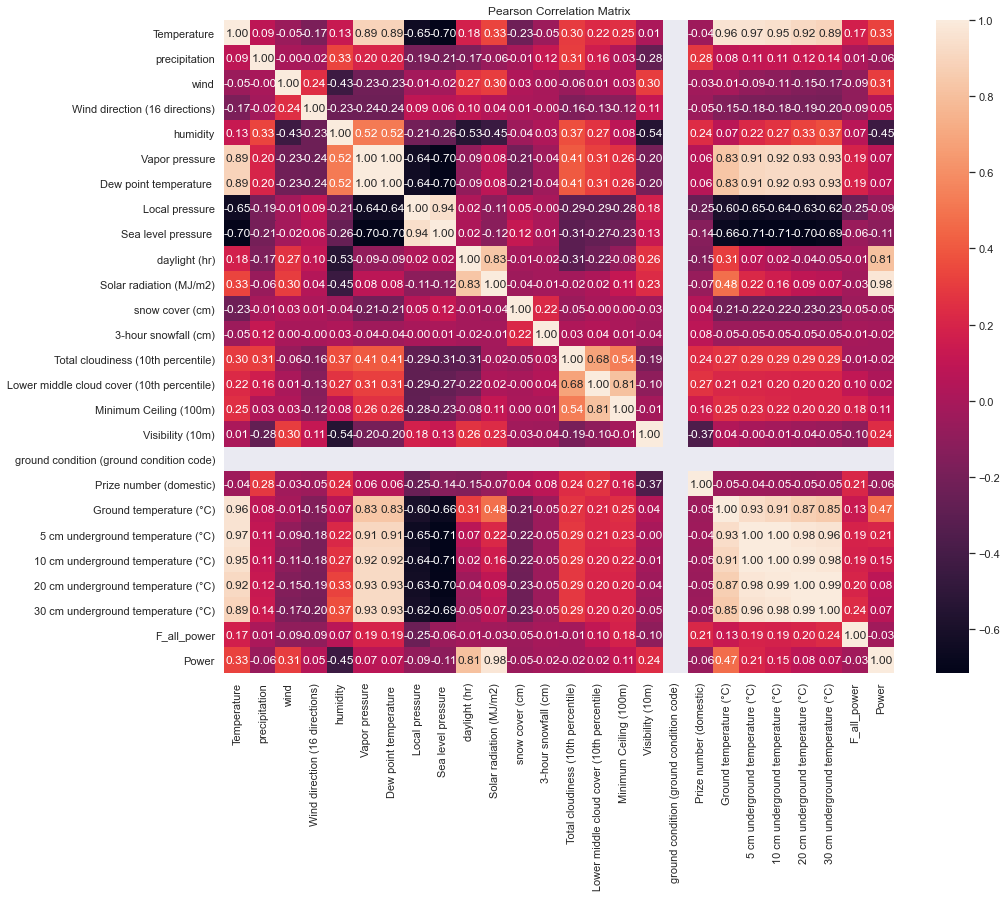

In [17]:
# Plot Pearson correlation matrix

correlations = df_merge.corr(method='spearman')
fig = plt.figure(figsize=(15, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [18]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Temperature                                 Vapor pressure                                0.892060
                                            Dew point temperature                         0.892072
                                            Ground temperature (°C)                       0.962790
                                            5 cm underground temperature (°C)             0.966170
                                            10 cm underground temperature (°C)            0.949208
                                            20 cm underground temperature (°C)            0.917382
                                            30 cm underground temperature (°C)            0.894034
Vapor pressure                              Temperature                                   0.892060
                                            Dew point temperature                         0.999992
                                            Ground temperature (°C)                       0.832130
          

## <a id='ref17'>Feature selection</a> 

In [19]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [20]:
train_end_idx = int(len(df_merge)*0.8)

#test_end_idx = int(len(df_merge))
#cv_end_idx = test_end_idx

In [21]:
df_final  = df_merge.copy()
df_final['solar_ss'] = df_final['Solar radiation (MJ/m2)']*df_final['daylight (hr)']
# Wind Direction (deg)            0.086512
# h_max                           0.035325
# Barometric Pressure (hPa)      -0.010425
# Sea Level Pressure (hPa)       -0.016479
# Precipitation (mm)             -0.092167
# Humidity (%)                   -0.548498
X = df_final[['Solar radiation (MJ/m2)','daylight (hr)','Ground temperature (°C)','humidity']].values
y = df_final['Power'].values

y = y.reshape(-1, 1)

In [22]:
#df_final.to_csv('df_final.csv')

In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [24]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [25]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [26]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1)

past_history = 168
future_target = 24

In [27]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=False)

In [28]:
print(y_train.shape)
print(X_train.shape)

(13848, 24)
(13848, 168, 5)


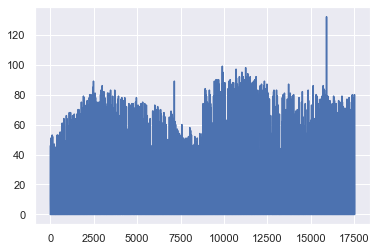

In [29]:
plt.plot(y.reshape(-1,))

In [30]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, None, past_history, 
                                 future_target, step=1, single_step=False)

In [31]:
print(X_val.shape)
print(y_val.shape)

(3312, 168, 5)
(3312, 24)


In [32]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   train_end_idx, None, past_history, 
                                   future_target, step=1, single_step=False)

In [33]:
print(X_test.shape)
print(y_test.shape)

(3312, 168, 5)
(3312, 24)


In [34]:
batch_size = 64
buffer_size = 1000

In [35]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [36]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [37]:
y_test.shape

(3312, 24)

In [38]:
#y_test = y_test.reshape(-1, 1)
y_test = y_test.reshape(-1, future_target)
y_test_inv = scaler_y.inverse_transform(y_test)

In [39]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

## 1. XG Boost

In [40]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [41]:
X_train_xgb.shape

(13848, 840)

## 2. LSTM

In [42]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [43]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
217/217 [==============================] - 22s 58ms/step - loss: 0.5289 - root_mean_squared_error: 0.6175 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1398- loss: 0.6293 - root_mean_squa - ETA: 0s - loss: 0.5581 - root_mean_squared_erro
Epoch 2/120
217/217 [==============================] - 11s 50ms/step - loss: 0.0193 - root_mean_squared_error: 0.1387 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 3/120
217/217 [==============================] - 11s 52ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311
Epoch 4/120
217/217 [==============================] - 11s 49ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314 - ETA: 0s - loss: 0.0161 - root_mean_squared_error
Epoch 5/120
217/217 [==============================] - 11s 49ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.0174 - val_root_mean_squared_error: 

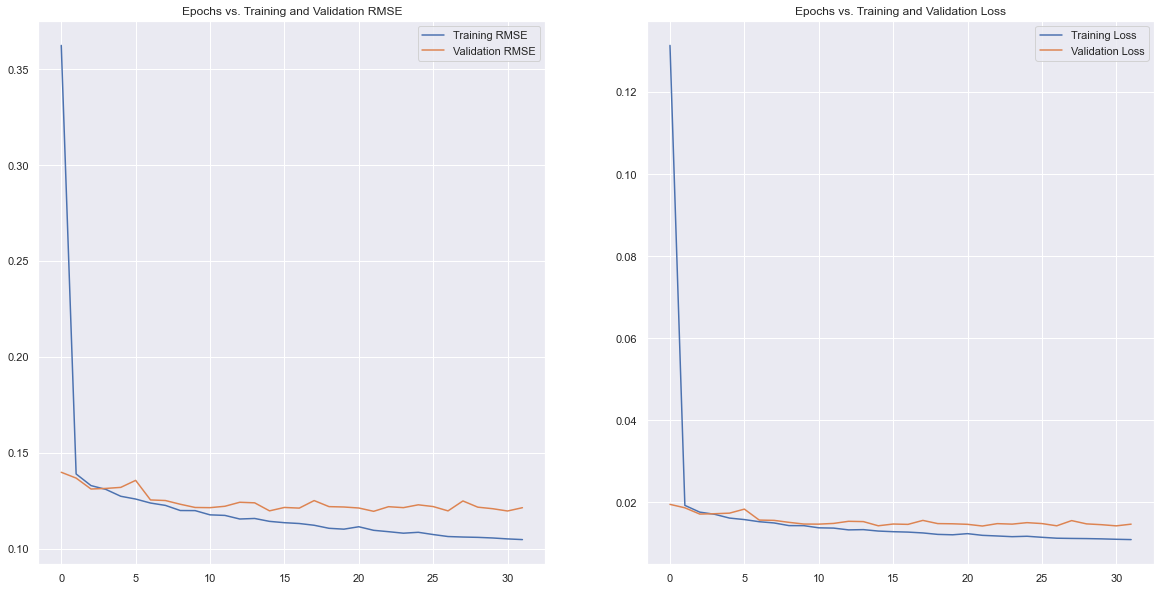

In [44]:
plot_model_rmse_and_loss(history)

In [86]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)
rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
r2_lstm = r2_score(y_test_inv,
                                    lstm_forecast)
mae_lstm = mean_absolute_error(y_test_inv,
                                    lstm_forecast)

print('R2 of day-ahead power generation LSTM forecast: {}'
      .format(round(r2_lstm, 3)))
print('RMSE of day-ahead power generation LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))
print('MAE of day-ahead power generation LSTM forecast: {}'
      .format(round(mae_lstm, 3)))

R2 of day-ahead power generation LSTM forecast: 0.731
RMSE of day-ahead power generation LSTM forecast: 11.822
MAE of day-ahead power generation LSTM forecast: 7.353


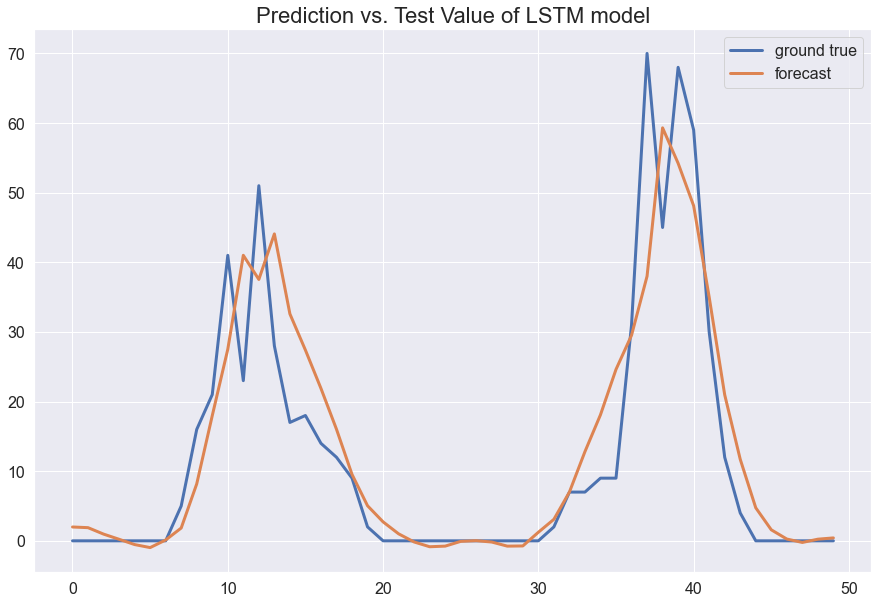

In [85]:
plt.figure(figsize=(15,10))
plt.plot(y_test_inv[:50,0],linewidth=3,label='ground true')
plt.plot(lstm_forecast[:50,0],linewidth=3,label='forecast')
plt.title('Prediction vs. Test Value of LSTM model',fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)


## Stacked LSTM

In [48]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [49]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
217/217 [==============================] - 21s 67ms/step - loss: 0.4384 - root_mean_squared_error: 0.4127 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661
Epoch 2/120
217/217 [==============================] - 14s 64ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474
Epoch 3/120
217/217 [==============================] - 12s 55ms/step - loss: 0.0200 - root_mean_squared_error: 0.1412 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431
Epoch 4/120
217/217 [==============================] - 11s 51ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1356
Epoch 5/120
217/217 [==============================] - 11s 53ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 6/120
217/217 [==============================] - 13s 59ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_l

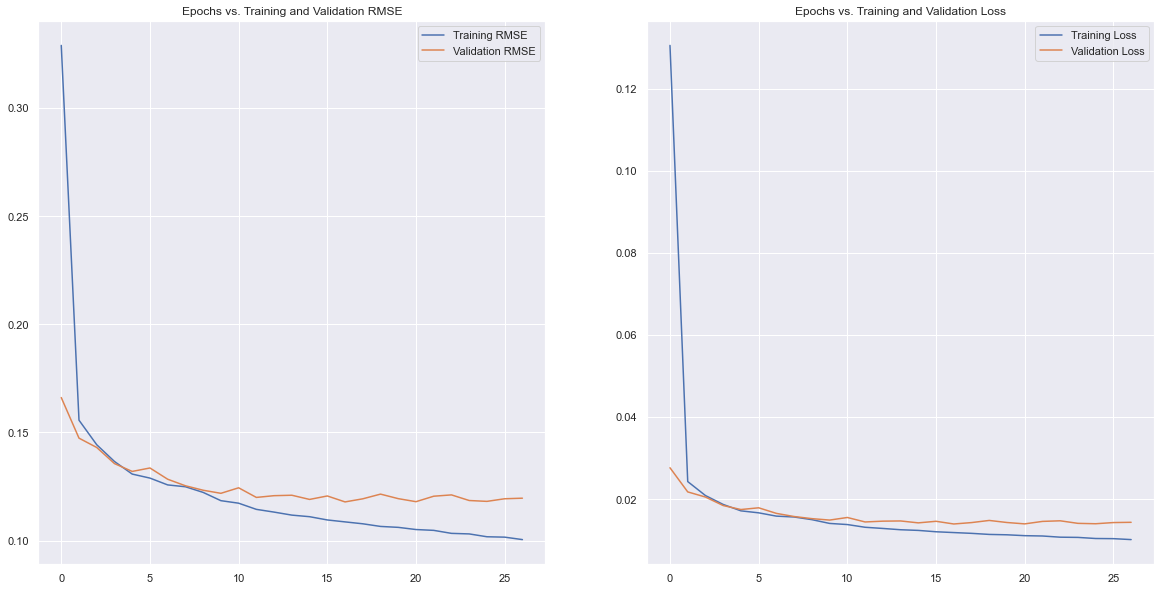

In [50]:
plot_model_rmse_and_loss(history)

In [87]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
r2_mult_stacked_lstm = r2_score(y_test_inv,
                                    multivariate_stacked_lstm_forecast)
mae_mult_stacked_lstm = mean_absolute_error(y_test_inv,
                                    multivariate_stacked_lstm_forecast)

print('R2 of day-ahead power generation multivariate Stacked LSTM forecast: {}'
      .format(round(r2_mult_stacked_lstm, 3)))
print('RMSE of day-ahead power generation multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))
print('MAE of day-ahead power generation multivariate Stacked LSTM forecast: {}'
      .format(round(mae_mult_stacked_lstm, 3)))



R2 of day-ahead power generation multivariate Stacked LSTM forecast: 0.738
RMSE of day-ahead power generation multivariate Stacked LSTM forecast: 11.674
MAE of day-ahead power generation multivariate Stacked LSTM forecast: 7.236


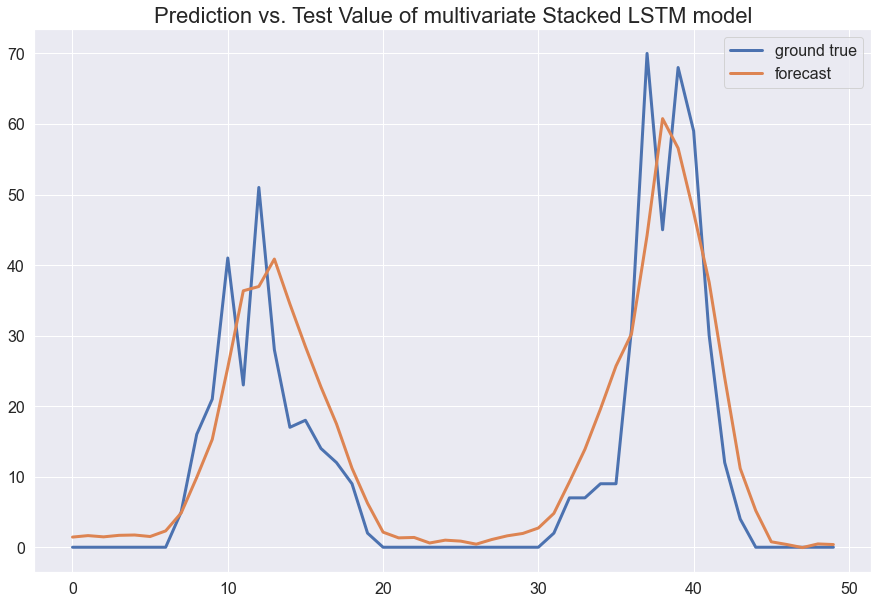

In [88]:
plt.figure(figsize=(15,10))
plt.plot(y_test_inv[:50,0],linewidth=3,label='ground true')
plt.plot(multivariate_stacked_lstm_forecast[:50,0],linewidth=3,label='forecast')
plt.title('Prediction vs. Test Value of multivariate Stacked LSTM model',fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

## 1D CNN

In [53]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [54]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
217/217 [==============================] - 6s 10ms/step - loss: 0.1058 - root_mean_squared_error: 0.2329 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1700
Epoch 2/120
217/217 [==============================] - 2s 8ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1659
Epoch 3/120
217/217 [==============================] - 2s 9ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1644
Epoch 4/120
217/217 [==============================] - 2s 10ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1673
Epoch 5/120
217/217 [==============================] - 2s 9ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1673
Epoch 6/120
217/217 [==============================] - 2s 9ms/step - loss: 0.0203 - root_mean_squared_error: 0.1426 - val_loss: 0.027

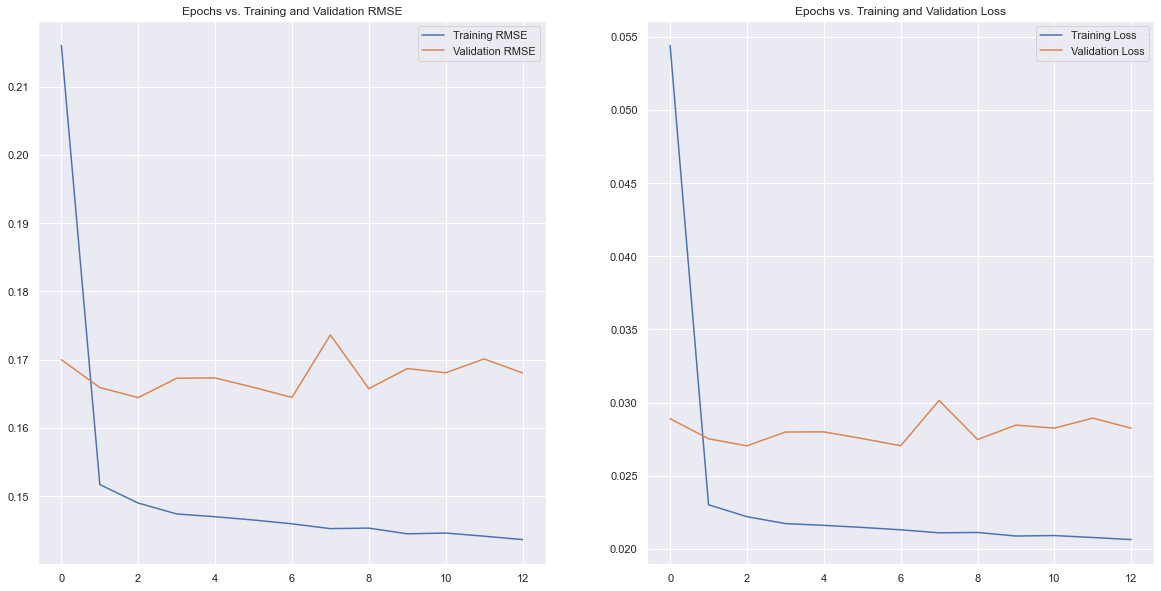

In [55]:
plot_model_rmse_and_loss(history)

In [91]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
r2_mult_cnn = r2_score(y_test_inv,
                                    multivariate_cnn_forecast)
mae_mult_cnn = mean_absolute_error(y_test_inv,
                                    multivariate_cnn_forecast)

print('R2 of day-ahead power generation multivariate CNN forecast: {}'
      .format(round(r2_mult_cnn, 3)))
print('RMSE of day-ahead power generation multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))
print('MAE of day-ahead power generation multivariate CNN forecast: {}'
      .format(round(mae_mult_cnn, 3)))

R2 of day-ahead power generation multivariate CNN forecast: 0.49
RMSE of day-ahead power generation multivariate CNN forecast: 16.28
MAE of day-ahead power generation multivariate CNN forecast: 13.107


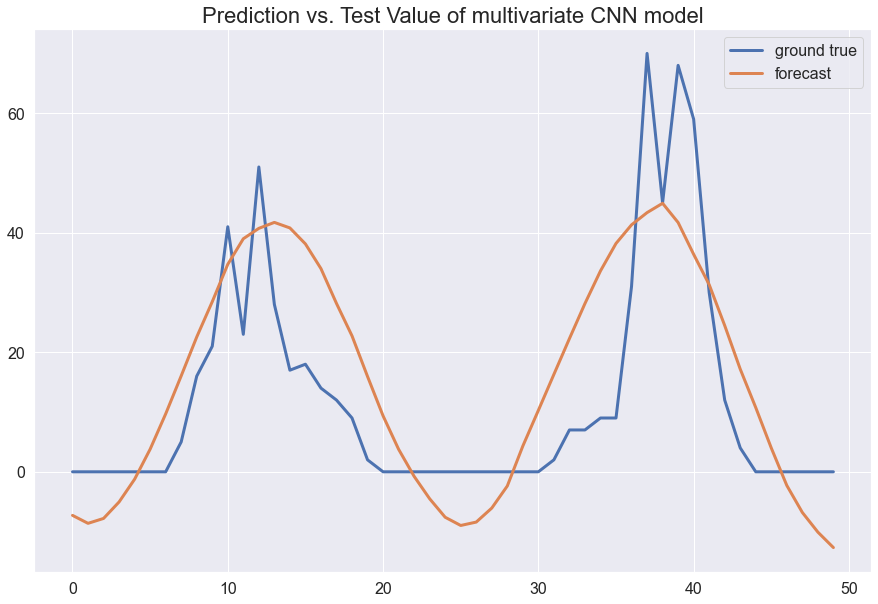

In [90]:
plt.figure(figsize=(15,10))
plt.plot(y_test_inv[:50,0],linewidth=3,label='ground true')
plt.plot(multivariate_cnn_forecast[:50,0],linewidth=3,label='forecast')
plt.title('Prediction vs. Test Value of multivariate CNN model',fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

## CNN-LSTM

In [57]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [58]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
217/217 [==============================] - 23s 72ms/step - loss: 0.0954 - root_mean_squared_error: 0.2340 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 2/120
217/217 [==============================] - 17s 78ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1369
Epoch 3/120
217/217 [==============================] - 16s 73ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1336
Epoch 4/120
217/217 [==============================] - 14s 67ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1281
Epoch 5/120
217/217 [==============================] - 16s 66ms/step - loss: 0.0119 - root_mean_squared_error: 0.1088 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264
Epoch 6/120
217/217 [==============================] - 14s 65ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_l

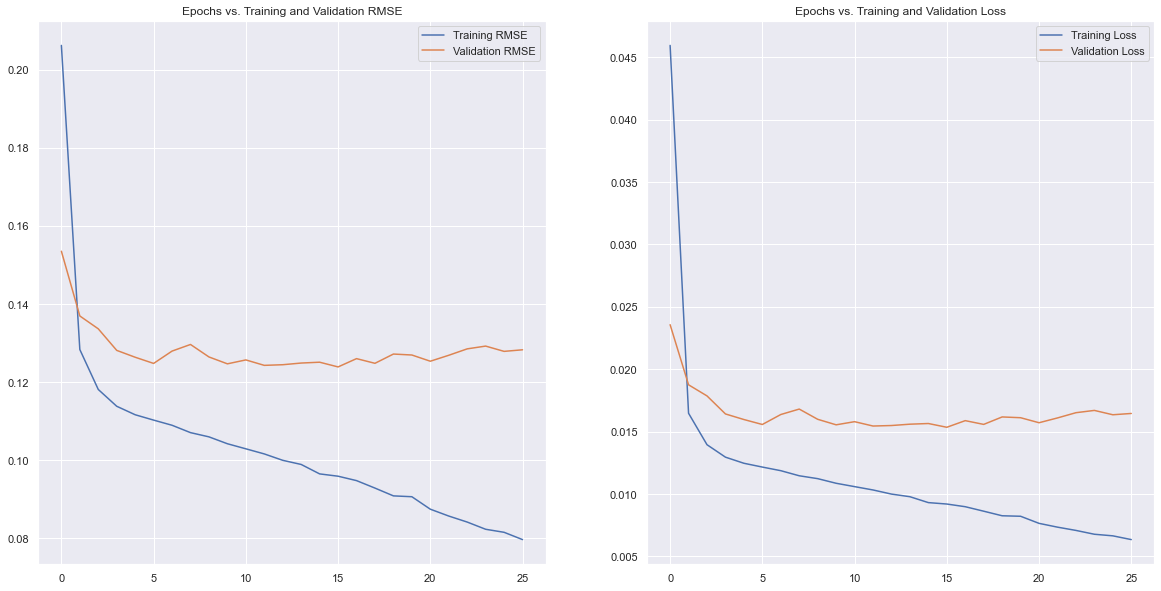

In [59]:
plot_model_rmse_and_loss(history)

In [92]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
r2_mult_cnn_lstm = r2_score(y_test_inv,
                                    multivariate_cnn_lstm_forecast)
mae_mult_cnn_lstm = mean_absolute_error(y_test_inv,
                                    multivariate_cnn_lstm_forecast)

print('R2 of day-ahead power generation multivariate CNN-LSTM forecast: {}'
      .format(round(r2_mult_cnn_lstm, 3)))
print('RMSE of day-ahead power generation multivariate CNN-LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))
print('RMSE of day-ahead power generation multivariate CNN-LSTM forecast: {}'
      .format(round(mae_mult_cnn_lstm, 3)))

R2 of day-ahead power generation multivariate CNN-LSTM forecast: 0.71
RMSE of day-ahead power generation multivariate CNN-LSTM forecast: 12.264
RMSE of day-ahead power generation multivariate CNN-LSTM forecast: 7.677


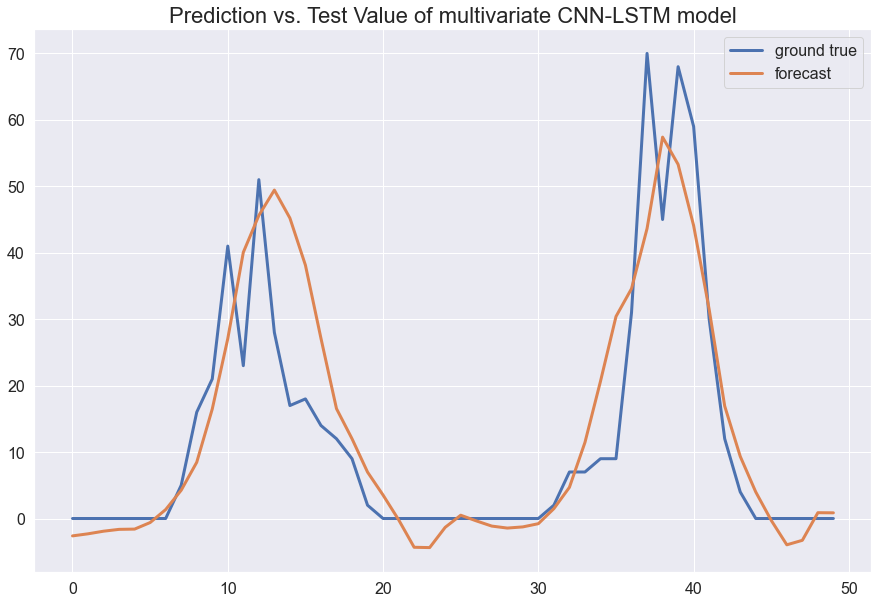

In [95]:
plt.figure(figsize=(15,10))
plt.plot(y_test_inv[:50,0],linewidth=3,label='ground true')
plt.plot(multivariate_cnn_lstm_forecast[:50,0],linewidth=3,label='forecast')
plt.title('Prediction vs. Test Value of multivariate CNN-LSTM model',fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

In [94]:
X_test.shape

(3312, 168, 5)

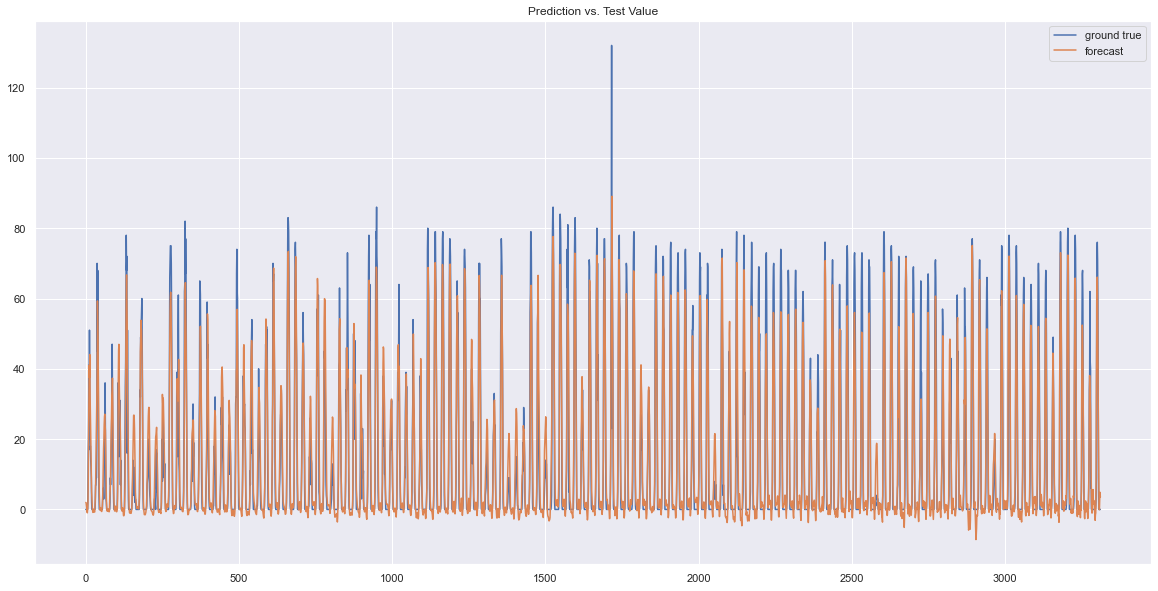

In [70]:
plt.figure(figsize=(20,10))
# y_plot,y_forecast = [],[]
# print(y_test_inv.shape)
# for i in range(len(y_test_inv)):
#     y_plot = y_plot+y_test_inv[i]
#     y_forecast = y_forecast+lstm_forecast[i]
plt.plot(y_test_inv[:,0],label='ground true')
plt.plot(lstm_forecast[:,0],label='forecast')
plt.title('Prediction vs. Test Value')
plt.legend()

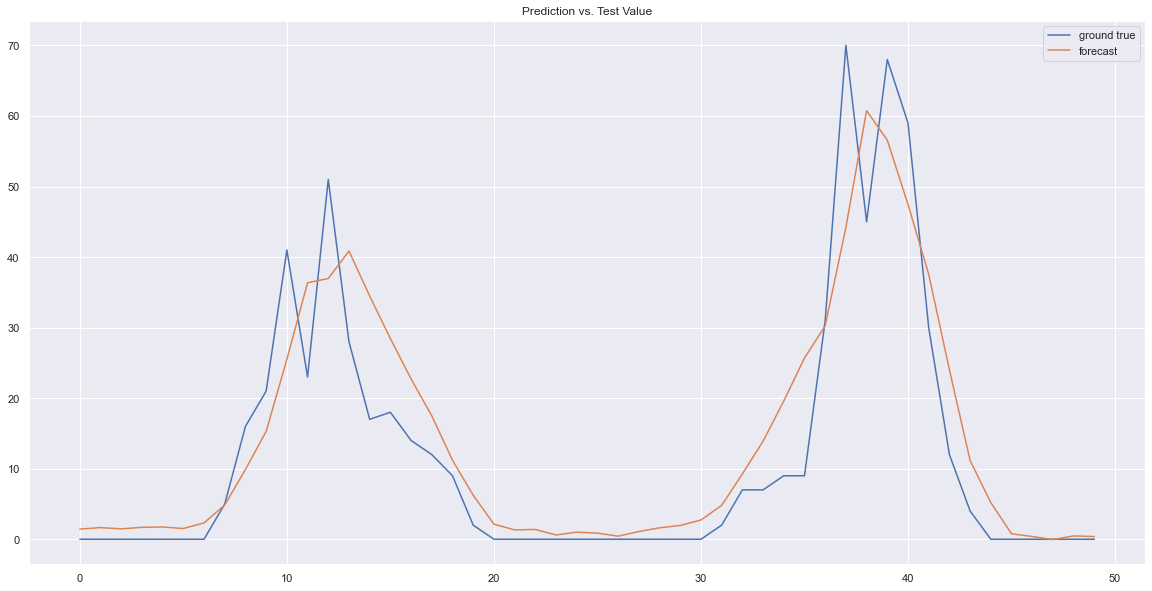

In [71]:
plt.figure(figsize=(20,10))
plt.plot(y_test_inv[:50,0],label='ground true')
plt.plot(multivariate_stacked_lstm_forecast[:50,0],label='forecast')
plt.title('Prediction vs. Test Value')
plt.legend()
